#Finetune Long Short Term Memory with GridSearch() class


###Reference

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

###Mounting to Google Drive


In [ ]:
#connecting gdrive into the google colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Import Libraries

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from keras.constraints import max_norm

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Activation, Dense, Dropout, Flatten, SimpleRNN
from tensorflow.keras import layers
from keras.constraints import max_norm

from keras.layers import Bidirectional

from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt

####Load the Dataset


In [ ]:
# change file path accordingly 
data=pd.read_csv("/content/gdrive/MyDrive/Depression Project/DepressionDataFinal2Processed.csv")
data = data.astype(str)
data.head()

,Id,Text,Target
0,2.85e+17,one thing love life mother one ever come mine,1
1,2.9e+17,want perfect want happy,0
2,2.86e+17,mom hates dad hates today sucks fword life tho,0
3,2.86e+17,hate hate life,0
4,2.86e+17,feel good,1


In [ ]:
data.columns

Index(['Id', 'Text', 'Target'], dtype='object')

### Train, Val, Test split --> 60%, 20%, 20% 

In [ ]:
# x_train is the training data set
# y_train is the corresponding labels to x_train 
# x_test is the test dataset 
# y_test is the corresponding label to x_test 
x_train, x_test, y_train, y_test = train_test_split(data, data.Target, test_size=0.2, random_state=1)
# 0.25 x 0.8 = 0.2
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) 

### Find Maximum Length of Tweets - max_len constant



In [ ]:
# find maximum length of tweet
def max_len(x):
    a=x.split()
    return len(a)

max(data['Text'].apply(max_len))

20

In [ ]:
# maxlen = 700 --> maximum length of tweet = 697
max_len = 700

### Convert Label into Term-Document Matrix

In [ ]:
# Bag of Words used to one-hot encode Target label 
# use CountVectorizer to covert the label into tokens
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","), binary='true')
y_train=vectorizer.fit_transform(x_train['Target']).toarray()
y_test=vectorizer.fit_transform(x_test['Target']).toarray()
y_val=vectorizer.fit_transform(x_val['Target']).toarray()

### Tokenize tweets using Tokenizer()

In [ ]:
vect=Tokenizer()
vect.fit_on_texts(data['Text'])

### Find Size of Vectorized Tokens  - vocab_size constant



In [ ]:
vocab_size = len(vect.word_index) + 1
print(vocab_size)

1989


### Turn the Vectorized Tokens into Sequences of Integers


In [ ]:
encoded_docs_train = vect.texts_to_sequences(x_train['Text'])
encoded_docs_test =  vect.texts_to_sequences(x_test['Text'])
encoded_docs_cv = vect.texts_to_sequences(x_val['Text'])

### Padding and Making all the Sequences the same Length

In [ ]:
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_len, padding='post')
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_len, padding='post')
padded_docs_cv = pad_sequences(encoded_docs_cv, maxlen=max_len, padding='post')

## Find Optimum Epoch and Batch Size 

In [ ]:
# Use scikit-learn to grid search the batch size and epochs
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model():
	# create model
  model = Sequential()
  # Configuring the parameters
  model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
  model.add(layers.Bidirectional(layers.LSTM(10, return_sequences=True)))  
  model.add(layers.Bidirectional(layers.LSTM(4)))
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(2, activation='sigmoid'))
	# Compile model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [64, 128, 256, 512, 1024]
epochs = [25]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train, validation_data = (padded_docs_cv, y_val))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.855738 using {'batch_size': 512, 'epochs': 10}
0.648327 (0.114393) with: {'batch_size': 512, 'epochs': 5}
0.855738 (0.026626) with: {'batch_size': 512, 'epochs': 10}


## Tune Optimisation Algorithm 

In [ ]:
from tensorflow.keras import layers
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam'):
  model = Sequential()
  # Configuring the parameters
  model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
  model.add(layers.Bidirectional(layers.LSTM(10, return_sequences=True)))
  model.add(layers.Bidirectional(layers.LSTM(4)))
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(2, activation='sigmoid'))
  # Compile model 
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# create model
model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=512, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train, validation_data = (padded_docs_cv, y_val))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.910191 using {'optimizer': 'RMSprop'}
0.531669 (0.019220) with: {'optimizer': 'SGD'}
0.910191 (0.006828) with: {'optimizer': 'RMSprop'}
0.531669 (0.019220) with: {'optimizer': 'Adagrad'}
0.494801 (0.036679) with: {'optimizer': 'Adadelta'}
0.908111 (0.004700) with: {'optimizer': 'Adam'}
0.901683 (0.007328) with: {'optimizer': 'Adamax'}
0.907733 (0.001753) with: {'optimizer': 'Nadam'}


## Tune Neuron Activation Function


In [ ]:
def create_model(activation='relu'):
	# create model
  model = Sequential()
  # Configuring the parameters
  model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
  model.add(layers.Bidirectional(layers.LSTM(10, return_sequences=True)))
  model.add(layers.Bidirectional(layers.LSTM(4)))
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(2, activation='sigmoid'))
  model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
	# Compile model
  return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# create model
model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=512, verbose=0)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train, validation_data = (padded_docs_cv, y_val))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.908867 using {'activation': 'tanh'}
0.908300 (0.006749) with: {'activation': 'softmax'}
0.907733 (0.001872) with: {'activation': 'softplus'}
0.887881 (0.022043) with: {'activation': 'softsign'}
0.907733 (0.004662) with: {'activation': 'relu'}
0.908867 (0.002331) with: {'activation': 'tanh'}
0.904141 (0.008836) with: {'activation': 'sigmoid'}
0.908489 (0.005583) with: {'activation': 'hard_sigmoid'}
0.904141 (0.008836) with: {'activation': 'linear'}


## Tune Learning Rate and Momentum

In [ ]:
def create_model(learn_rate=0.01, momentum=0):
  # create model
  model = Sequential()
  # Configuring the parameters
  model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
  model.add(layers.Bidirectional(layers.LSTM(10, return_sequences=True)))
  model.add(layers.Bidirectional(layers.LSTM(4)))
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(2, activation='sigmoid'))
  model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
  return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=512, verbose=0)
# define the grid search parameters
learn_rate = [0.2, 0.3, 0.4, 0.6]
momentum = [0.8]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train, validation_data = (padded_docs_cv, y_val))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.910002 using {'learn_rate': 0.4, 'momentum': 0.8}
0.905464 (0.006167) with: {'learn_rate': 0.2, 'momentum': 0.8}
0.905842 (0.004245) with: {'learn_rate': 0.3, 'momentum': 0.8}
0.910002 (0.008159) with: {'learn_rate': 0.4, 'momentum': 0.8}
0.893364 (0.027676) with: {'learn_rate': 0.6, 'momentum': 0.8}


## Tune Dropout Regularization

In [ ]:
def create_model(dropout_rate=0.0, weight_constraint=0):
	# create model
  model = Sequential()
  # Configuring the parameters
  model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
  model.add(layers.Bidirectional(layers.LSTM(10, return_sequences=False)))
  #model.add(layers.Bidirectional(layers.LSTM(4)))
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(2, activation='sigmoid'))
  model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
	# Compile model
  return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=512, verbose=0)
# define the grid search parameters
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train, validation_data = (padded_docs_cv, y_val))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.914540 using {'dropout_rate': 0.7, 'weight_constraint': 4}
0.907355 (0.003084) with: {'dropout_rate': 0.0, 'weight_constraint': 1}
0.910758 (0.004865) with: {'dropout_rate': 0.0, 'weight_constraint': 2}
0.911325 (0.003350) with: {'dropout_rate': 0.0, 'weight_constraint': 3}
0.905086 (0.006952) with: {'dropout_rate': 0.0, 'weight_constraint': 4}
0.912271 (0.003476) with: {'dropout_rate': 0.0, 'weight_constraint': 5}
0.914161 (0.002978) with: {'dropout_rate': 0.1, 'weight_constraint': 1}
0.910191 (0.004450) with: {'dropout_rate': 0.1, 'weight_constraint': 2}
0.910569 (0.002139) with: {'dropout_rate': 0.1, 'weight_constraint': 3}
0.911325 (0.001872) with: {'dropout_rate': 0.1, 'weight_constraint': 4}
0.902061 (0.014604) with: {'dropout_rate': 0.1, 'weight_constraint': 5}
0.912271 (0.001166) with: {'dropout_rate': 0.2, 'weight_constraint': 1}
0.908867 (0.001872) with: {'dropout_rate': 0.2, 'weight_constraint': 2}
0.906977 (0.003957) with: {'dropout_rate': 0.2, 'weight_constraint': 

## Tune Network Weight Initialization

In [ ]:
def create_model(init_mode= 'uniform'):
	# create model
  model = Sequential()
  # Configuring the parameters
  model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
  model.add(layers.Bidirectional(layers.LSTM(10, return_sequences=False)))
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(2, activation='sigmoid', kernel_initializer=init_mode))
  model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
	# Compile model
  return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=512, verbose=0)
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.914729 using {'init_mode': 'glorot_normal'}
0.823029 (0.115668) with: {'init_mode': 'uniform'}
0.912082 (0.001604) with: {'init_mode': 'lecun_uniform'}
0.910947 (0.000926) with: {'init_mode': 'normal'}
0.906220 (0.004685) with: {'init_mode': 'zero'}
0.914729 (0.002633) with: {'init_mode': 'glorot_normal'}
0.905464 (0.008755) with: {'init_mode': 'glorot_uniform'}
0.905086 (0.007918) with: {'init_mode': 'he_normal'}
0.912460 (0.001626) with: {'init_mode': 'he_uniform'}


## Tune the Number of Neurons in the Hidden Layer

In [ ]:
def create_model(neurons=1):
	# create model
  model = Sequential()
  # Configuring the parameters
  model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
  model.add(LSTM(128, return_sequences=True))  
  model.add(LSTM(4))
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(2, activation='sigmoid', kernel_initializer='he_uniform'))
  model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
	# Compile model
  return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=512, verbose=0)
# define the grid search parameters
neurons = [25, 30, 35, 40, 45, 50]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.531669 using {'neurons': 25}
0.531669 (0.019220) with: {'neurons': 25}
0.531669 (0.019220) with: {'neurons': 30}
0.531669 (0.019220) with: {'neurons': 35}
0.531669 (0.019220) with: {'neurons': 40}
0.531669 (0.019220) with: {'neurons': 45}
0.531669 (0.019220) with: {'neurons': 50}


### Build and compile DL Model

In [ ]:
model = Sequential()
# Configuring the parameters
model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(45, kernel_constraint=max_norm(2))))
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(2, activation='tanh', kernel_initializer='glorot_normal'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 700, 50)           99450     
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 90)                34560     
_________________________________________________________________
dropout_13 (Dropout)         (None, 90)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 182       
Total params: 134,192
Trainable params: 134,192
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import numpy as np
import tensorflow as tf

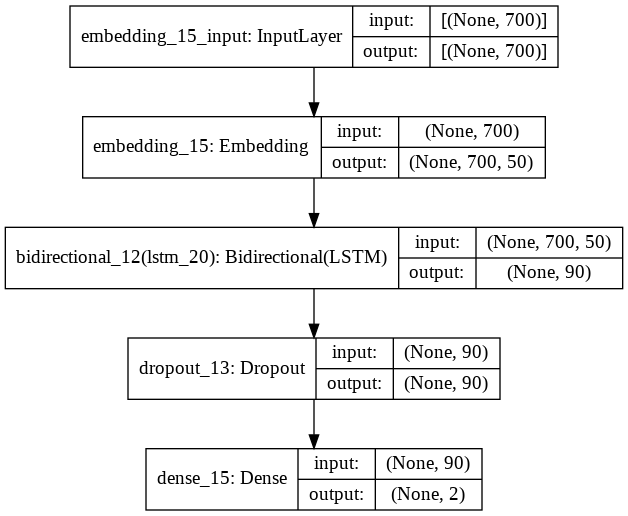

In [ ]:
# plot NN model 
plot_model(model, to_file='/content/gdrive/MyDrive/Depression Project/mlp-mnist.png', show_shapes=True)

In [ ]:
# compile the model 
opt = tf.keras.optimizers.RMSprop(learning_rate=0.4, momentum=0.8)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(padded_docs_train, y_train,
                    epochs=25, batch_size = 512, 
                    validation_data = (padded_docs_cv, y_val)
                    )

Epoch 1/25
11/11 [==============================] - 5s 218ms/step - loss: 2.8569 - accuracy: 0.5264 - val_loss: 1.0705 - val_accuracy: 0.7124
Epoch 2/25
11/11 [==============================] - 2s 155ms/step - loss: 1.0402 - accuracy: 0.5392 - val_loss: 0.7540 - val_accuracy: 0.6313
Epoch 3/25
11/11 [==============================] - 2s 156ms/step - loss: 0.7603 - accuracy: 0.5268 - val_loss: 0.6827 - val_accuracy: 0.5485
Epoch 4/25
11/11 [==============================] - 2s 157ms/step - loss: 0.7225 - accuracy: 0.5294 - val_loss: 0.6926 - val_accuracy: 0.5406
Epoch 5/25
11/11 [==============================] - 2s 156ms/step - loss: 0.7175 - accuracy: 0.5579 - val_loss: 0.6747 - val_accuracy: 0.6869
Epoch 6/25
11/11 [==============================] - 2s 155ms/step - loss: 0.6988 - accuracy: 0.5915 - val_loss: 0.6578 - val_accuracy: 0.8361
Epoch 7/25
11/11 [==============================] - 2s 154ms/step - loss: 0.6740 - accuracy: 0.6368 - val_loss: 0.6189 - val_accuracy: 0.8520
Epoch 

### Evaluate the Model


In [ ]:
model.evaluate(padded_docs_test, y_test)

56/56 [==============================] - 1s 18ms/step - loss: 0.2864 - accuracy: 0.9206


[0.286362886428833, 0.9205899238586426]

### Plot Results in a Graph 

In [ ]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

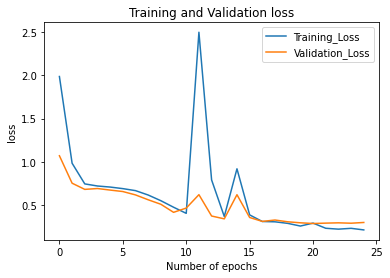

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

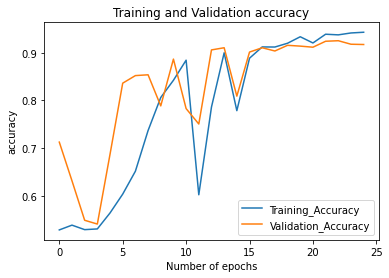

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')